In [1]:
import os 
os.chdir('E:\Ecole\Year 3\Projet 3A')
import pandas as pd
import numpy as np 

class Domain:
    
    def __init__(self, name):
        self.name = name
        self.thresholds = None
        self.thetas = None

class Peptide:
    
    def __init__(self, name):
        self.name = name
        self.sequence = None
        self.sequence_bis = None ##Sequence bis are the last five amino acids
        self.energy_ground = 0.0 ##Anticipating the calculation of a ground state energy for the peptide
        
class Data:
    
    def __init__(self):
        temp_df = pd.read_excel('Data_PDZ/theta_data.xlsx')
        self.aminoacids = [acid.encode('utf-8') for acid in list(temp_df.columns[:20])]
        self.df = temp_df.T
        self.domains = [Domain(domain.encode('utf-8')) for domain in list(self.df.columns)]
        self.domain_names = [domain.name for domain in self.domains]
        self.pep_seqs = []
        self.pep_names = []
        with open('Data_PDZ/peptides.free') as f:
            for line in f:
                x = line.split()
                self.pep_seqs.append(x[1])
                self.pep_names.append(x[0])
        self.peptides = [Peptide(name) for name in self.pep_names]
        
    def create_domains(self):
        for domain in self.domains:
            domain.thetas = self.df[domain.name][:100]
            domain.thetas = np.asarray(domain.thetas)
            domain.thetas = domain.thetas.reshape(5,20)
            domain.thresholds = np.asarray(self.df[domain.name][100:])   
    
    def create_peptides(self):
        for i in range(len(self.pep_seqs)):
            self.peptides[i].sequence = self.pep_seqs[i]
            self.peptides[i].sequence_bis = list(self.pep_seqs[i])[5:]        

In [2]:
PDZ_Data = Data()
PDZ_Data.create_domains()
PDZ_Data.create_peptides()

In [3]:
fp_interaction_matrix = pd.read_excel('Data_PDZ/fp_interaction_matrix.xlsx')
for column in fp_interaction_matrix.columns:
    fp_interaction_matrix.loc[fp_interaction_matrix[column] == 0.0, column] = -1.0
fp_interaction_matrix = fp_interaction_matrix.rename(columns=lambda x: str(x).replace(" ", ""))

Calculate the $P(y_{manip})$ using the interaction table. This enters as supplementary data for each of the peptides.

In [4]:
def calc_y_manip():
    bind = 0.0
    nbind = 0.0
    for i in range(len(PDZ_Data.domain_names)):
        for peptide in PDZ_Data.peptides:
                alpha = fp_interaction_matrix[peptide.name][i]
                if alpha > 0:
                    bind +=1
                else:
                    nbind +=1
    PDZ_Data.y_manip_bind = bind/np.size(fp_interaction_matrix)
    PDZ_Data.y_manip_nbind = nbind/np.size(fp_interaction_matrix)

def calc_bind_prob(peptide):
    bind = 0.0
    nbind = 0.0
    for i in range(len(PDZ_Data.domain_names)):
        alpha = fp_interaction_matrix[peptide.name][i]
        if alpha > 0:
            bind +=1
        else:
            nbind +=1
    peptide.y_manip_bind = bind/74
    peptide.y_manip_nbind = nbind/74
    


In [5]:
test_peptide = PDZ_Data.peptides[1]
print test_peptide.name

APC


In [6]:
calc_y_manip()

In [7]:
print PDZ_Data.y_manip_bind

0.0335658238884


In [8]:
print PDZ_Data.y_manip_nbind

0.966434176112


Now we need to calculate the terms such as $P(y_{model}|y_{manip})$ into the object PDZ_Data. 

In [9]:
class_matrix = np.zeros((2,2))

In [10]:
class_matrix

array([[ 0.,  0.],
       [ 0.,  0.]])

In [11]:
class_matrix[0,0] = 0.85
class_matrix[0,1] = 0.04
class_matrix[1,0] = 0.15
class_matrix[1,1] = 0.96

In [12]:
class_matrix

array([[ 0.85,  0.04],
       [ 0.15,  0.96]])

In [13]:
for peptide in PDZ_Data.peptides:
    calc_bind_prob(peptide)
    peptide.y_model_bind = class_matrix[1,1]*peptide.y_manip_bind + class_matrix[1,0]*peptide.y_manip_nbind
    peptide.y_model_nbind = class_matrix[0,0]*peptide.y_manip_nbind + class_matrix[0,1]*peptide.y_manip_bind
    ## P(y_manip|y_model) = P(y_model|y_manip)*P(y_manip) / P(y_model)
    ## P(manip=-1|model=-1) = P(model=-1|manip=-1) * P(manip=-1) /P(model=-1)
    peptide.posterior_matrix = np.zeros((2,2))
    peptide.posterior_matrix[0,0] = class_matrix[0,0]*peptide.y_manip_nbind / peptide.y_model_nbind
    ## P(manip=1|model=-1) = P(model=-1|manip=1) * P(manip=1) /P(model=-1)
    peptide.posterior_matrix[1,0] = class_matrix[0,1]*peptide.y_manip_bind / peptide.y_model_nbind
    ## P(manip=-1|model=1) = P(model=1|manip=-1) * P(manip=-1) /P(model=1)
    peptide.posterior_matrix[0,1] = class_matrix[1,0]*peptide.y_manip_nbind / peptide.y_model_bind
    ## P(manip=1|model=1) = P(model=1|manip=1) * P(manip=1) /P(model=1)
    peptide.posterior_matrix[1,1] = class_matrix[1,1]*peptide.y_manip_bind / peptide.y_model_bind

In [14]:
ix = PDZ_Data.pep_names.index('AcvR1')
for_test = PDZ_Data.peptides[15]

print for_test.name
print for_test.y_model_nbind
print for_test.y_manip_bind
print for_test.y_manip_nbind
print for_test.posterior_matrix

EphB2
0.839054054054
0.0135135135135
0.986486486486
[[  9.99355774e-01   9.19395466e-01]
 [  6.44226123e-04   8.06045340e-02]]


In [15]:
PDZ_Data.y_model_bind = class_matrix[1,1]*PDZ_Data.y_manip_bind + class_matrix[1,0]*PDZ_Data.y_manip_nbind

In [16]:
PDZ_Data.y_model_nbind = class_matrix[0,0]*PDZ_Data.y_manip_nbind + class_matrix[0,1]*PDZ_Data.y_manip_bind

In [17]:
print PDZ_Data.y_model_bind

0.17718831735


In [18]:
print PDZ_Data.y_model_nbind

0.82281168265


In [19]:
posterior_matrix = np.zeros((2,2))

In [20]:
## P(y_manip|y_model) = P(y_model|y_manip)*P(y_manip) / P(y_model)
## P(manip=-1|model=-1) = P(model=-1|manip=-1) * P(manip=-1) /P(model=-1)
posterior_matrix[0,0] = class_matrix[0,0]*PDZ_Data.y_manip_nbind / PDZ_Data.y_model_nbind
## P(manip=1|model=-1) = P(model=-1|manip=1) * P(manip=1) /P(model=-1)
posterior_matrix[1,0] = class_matrix[0,1]*PDZ_Data.y_manip_bind / PDZ_Data.y_model_nbind
## P(manip=-1|model=1) = P(model=1|manip=-1) * P(manip=-1) /P(model=1)
posterior_matrix[0,1] = class_matrix[1,0]*PDZ_Data.y_manip_nbind / PDZ_Data.y_model_bind
## P(manip=1|model=1) = P(model=1|manip=1) * P(manip=1) /P(model=1)
posterior_matrix[1,1] = class_matrix[1,1]*PDZ_Data.y_manip_bind / PDZ_Data.y_model_bind


In [21]:
print posterior_matrix

[[ 0.99836824  0.81814156]
 [ 0.00163176  0.18185844]]


In [22]:
PDZ_Data.posterior_matrix = posterior_matrix
PDZ_Data.class_matrix = class_matrix

In [23]:
print PDZ_Data.posterior_matrix

[[ 0.99836824  0.81814156]
 [ 0.00163176  0.18185844]]


In [24]:
print PDZ_Data.class_matrix

[[ 0.85  0.04]
 [ 0.15  0.96]]


In [31]:
for peptide in PDZ_Data.peptides:
    calc_bind_prob(peptide)
binds = [peptide.y_manip_bind for peptide in PDZ_Data.peptides]
model_binds = [peptide.y_model_bind for peptide in PDZ_Data.peptides]

(array([ 104.,   29.,   16.,   15.,   12.,    7.,    8.,    7.,    4.,
           3.,    0.,    2.,    2.,    1.,    1.,    0.,    0.,    1.,
           1.,    1.,    1.,    0.,    1.,    0.,    1.]),
 array([ 0.15      ,  0.16094595,  0.17189189,  0.18283784,  0.19378378,
         0.20472973,  0.21567568,  0.22662162,  0.23756757,  0.24851351,
         0.25945946,  0.27040541,  0.28135135,  0.2922973 ,  0.30324324,
         0.31418919,  0.32513514,  0.33608108,  0.34702703,  0.35797297,
         0.36891892,  0.37986486,  0.39081081,  0.40175676,  0.4127027 ,
         0.42364865]),
 <a list of 1 Patch objects>)

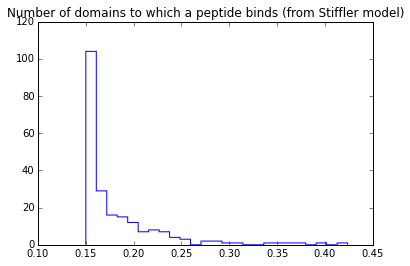

In [32]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.title("Number of domains to which a peptide binds (from Stiffler model)") 
plt.hist(model_binds, bins=25, histtype='step')

(array([ 104.,   29.,   16.,   15.,   12.,    7.,    8.,    7.,    4.,
           3.,    0.,    2.,    2.,    1.,    1.,    0.,    0.,    1.,
           1.,    1.,    1.,    0.,    1.,    0.,    1.]),
 array([ 0.        ,  0.01351351,  0.02702703,  0.04054054,  0.05405405,
         0.06756757,  0.08108108,  0.09459459,  0.10810811,  0.12162162,
         0.13513514,  0.14864865,  0.16216216,  0.17567568,  0.18918919,
         0.2027027 ,  0.21621622,  0.22972973,  0.24324324,  0.25675676,
         0.27027027,  0.28378378,  0.2972973 ,  0.31081081,  0.32432432,
         0.33783784]),
 <a list of 1 Patch objects>)

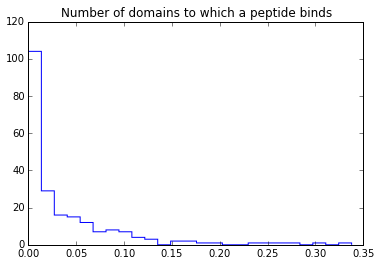

In [33]:
import matplotlib.pyplot as plt
plt.title("Number of domains to which a peptide binds")
plt.hist(binds,bins=25, histtype='step')

Let us now calculate the values $P(y_{manip}|seq)$ for a given peptide and compare it to the value calculated naively without taking into account the errors. 

In [34]:
def sigmoid(x, a=1):
    return 1.0/(1+np.exp(-1.0*a*x))
def log_modified(x):
    if x > 0:
        return np.log(1+np.exp(-x))
    else:
        return -x + np.log(1+np.exp(x)) 
## Convenience functions to convert between letter sequences and indexed sequences. 
## The index for each amino acid is computed using the enumeration presented in the file "MDSM_01_stiffler_bis.xls" 
def convert2seq(seq_int):
    return [PDZ_Data.aminoacids[i] for i in seq_int]
def convert2int(seq_pep):
    return [PDZ_Data.aminoacids.index(pep) for pep in seq_pep]

In [46]:
def eval_score(domain, sequence,pos=0):
    score = 0.0
    for i in range(5):
        score += domain.thetas[i,sequence[i]]
    return score - domain.thresholds[pos]
def calc_posterior(peptide,pos):
    peptide.energies = [eval_score(domain, convert2int(peptide.sequence_bis),pos) for domain in PDZ_Data.domains]
    peptide.prob_post_bind_list = [peptide.posterior_matrix[1,0]*sigmoid(energy,-1) + peptide.posterior_matrix[1,1]*sigmoid(energy) for energy in peptide.energies]
    true_interactions = []
    for i in range(len(PDZ_Data.domains)):
        if fp_interaction_matrix[peptide.name][i] >0:
            true_interactions.append(peptide.prob_post_bind_list[i])
    if len(true_interactions) == 0:
        peptide.lower_prob = 0
    else:
        peptide.lower_prob = np.min(true_interactions)
    

In [56]:
ix = PDZ_Data.pep_names.index('Kv1.7')
pep_demo = PDZ_Data.peptides[ix]
energies = [eval_score(domain, convert2int(pep_demo.sequence_bis),2) for domain in PDZ_Data.domains]
calc_posterior(pep_demo,0)
print pep_demo.posterior_matrix
print pep_demo.y_manip_bind*74
print pep_demo.lower_prob

[[ 0.99007065  0.42302358]
 [ 0.00992935  0.57697642]]
13.0
0.274631253628


In [57]:
# Calculate P(y_manip|seq) for given sequence and a given Domain
for i in range(len(energies)):
    print "{}\t {}\t {}\t".format(PDZ_Data.domains[i].name, energies[i], fp_interaction_matrix[pep_demo.name][i])

Cipp (03/10)	 -8.14647	 -1.0	
Cipp (05/10)	 -19.60901	 -1.0	
Cipp (08/10)	 12.1962	 17896.25943	
Cipp (09/10)	 -8.94231	 -1.0	
Cipp (10/10)	 -1.98574	 -1.0	
D930005D10Rik (1/1)	 -6.81225	 -1.0	
Dlgh3 (1/1)	 -10.89372	 -1.0	
Dvl1 (1/1)	 -10.82181	 -1.0	
Dvl2 (1/1)	 -10.33306	 -1.0	
Dvl3 (1/1)	 -8.65079	 -1.0	
Erbin (1/1)	 -5.366669	 -1.0	
Gm1582 (2/3)	 6.7366	 25720.02273	
GRASP55 (1/1)	 -9.33836	 -1.0	
Grip1 (6/7)	 -19.56178	 -1.0	
Grip2 (5/7)	 7.38578	 12536.37452	
Harmonin (2/3)	 -7.97413	 -1.0	
HtrA1 (1/1)	 28.55	 3788.65461	
HtrA3 (1/1)	 -23.0333	 -1.0	
Interleukin 16 (1/4)	 -10.85698	 -1.0	
LARG (1/1)	 5.94835	 12057.93739	
LIN-7A (1/1)	 -6.95096	 -1.0	
Lin7c (1/1)	 -18.44157	 -1.0	
Lnx1 (2/4)	 -4.85857	 -1.0	
Lrrc7 (1/1)	 -7.11262	 -1.0	
Magi-1 (2/6)	 2.575598	 -1.0	
Magi-1 (4/6)	 -7.903327	 -1.0	
Magi-1 (6/6)	 -11.58425	 -1.0	
Magi-2 (5/6)	 -5.47664	 -1.0	
Magi-2 (6/6)	 6.8568	 79666.25935	
Magi-3 (2/5)	 -2.99999999989e-05	 12402.81668	
Magi-3 (5/5)	 -3.10561519	 -1.0	
Mpp7 (1/1

(array([  1.,   1.,   0.,   0.,   0.,   1.,   1.,   3.,   3.,  10.,  12.,
         19.,   5.,   5.,   5.,   2.,   2.,   2.,   1.,   0.,   0.,   0.,
          0.,   0.,   1.]),
 array([-39.2495 , -36.53752, -33.82554, -31.11356, -28.40158, -25.6896 ,
        -22.97762, -20.26564, -17.55366, -14.84168, -12.1297 ,  -9.41772,
         -6.70574,  -3.99376,  -1.28178,   1.4302 ,   4.14218,   6.85416,
          9.56614,  12.27812,  14.9901 ,  17.70208,  20.41406,  23.12604,
         25.83802,  28.55   ]),
 <a list of 1 Patch objects>)

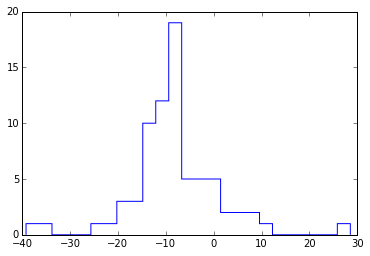

In [58]:
plt.hist(energies, bins=25, histtype='step')

In [59]:
for i in range(len(pep_demo.prob_post_bind_list)):
    print "{}\t {}\t {}\t".format(PDZ_Data.domain_names[i], pep_demo.prob_post_bind_list[i], fp_interaction_matrix[pep_demo.name][i])

Cipp (03/10)	 0.0100936067855	 -1.0	
Cipp (05/10)	 0.00992961970769	 -1.0	
Cipp (08/10)	 0.576976383314	 17896.25943	
Cipp (09/10)	 0.0102412659416	 -1.0	
Cipp (10/10)	 0.0947308661773	 -1.0	
D930005D10Rik (1/1)	 0.0105525367089	 -1.0	
Dlgh3 (1/1)	 0.0099398812934	 -1.0	
Dvl1 (1/1)	 0.0099427382724	 -1.0	
Dvl2 (1/1)	 0.00994779961461	 -1.0	
Dvl3 (1/1)	 0.0104275125406	 -1.0	
Erbin (1/1)	 0.0125649585364	 -1.0	
Gm1582 (2/3)	 0.576951980821	 25720.02273	
GRASP55 (1/1)	 0.0100015900402	 -1.0	
Grip1 (6/7)	 0.00992935067539	 -1.0	
Grip2 (5/7)	 0.576953037068	 12536.37452	
Harmonin (2/3)	 0.010124490065	 -1.0	
HtrA1 (1/1)	 0.576976421637	 3788.65461	
HtrA3 (1/1)	 0.0166748458358	 -1.0	
Interleukin 16 (1/4)	 0.00996546912286	 -1.0	
LARG (1/1)	 0.575706126056	 12057.93739	
LIN-7A (1/1)	 0.0106187484743	 -1.0	
Lin7c (1/1)	 0.00992937167576	 -1.0	
Lnx1 (2/4)	 0.0184629272544	 -1.0	
Lrrc7 (1/1)	 0.0104216098866	 -1.0	
Magi-1 (2/6)	 0.536871734362	 -1.0	
Magi-1 (4/6)	 0.0101388022379	 -1.0	
Magi-1

In [60]:
count = 0
for i in range(len(pep_demo.prob_post_bind_list)):
    if (pep_demo.prob_post_bind_list[i] > pep_demo.lower_prob) & (fp_interaction_matrix[pep_demo.name][i] < 0):
        count +=1
        print "{}\t {}\t {}\t".format(PDZ_Data.domain_names[i], pep_demo.prob_post_bind_list[i], fp_interaction_matrix[pep_demo.name][i])
        
print count

Magi-1 (2/6)	 0.536871734362	 -1.0	
Magi-3 (5/5)	 0.276403211452	 -1.0	
Shank1 (1/1)	 0.568194078226	 -1.0	
3


In [61]:
pep_demo.lower_prob

0.27463125362783841

In [62]:
pep_demo.posterior_matrix

array([[ 0.99007065,  0.42302358],
       [ 0.00992935,  0.57697642]])

In [63]:
for i in range(len(pep_demo.prob_post_bind_list)):
    if fp_interaction_matrix[pep_demo.name][i] > 0:
        print "{}\t {}\t {}\t".format(PDZ_Data.domain_names[i], pep_demo.prob_post_bind_list[i], fp_interaction_matrix[pep_demo.name][i])


Cipp (08/10)	 0.576976383314	 17896.25943	
Gm1582 (2/3)	 0.576951980821	 25720.02273	
Grip2 (5/7)	 0.576953037068	 12536.37452	
HtrA1 (1/1)	 0.576976421637	 3788.65461	
LARG (1/1)	 0.575706126056	 12057.93739	
Magi-2 (6/6)	 0.576950940138	 79666.25935	
Magi-3 (2/5)	 0.293448632397	 12402.81668	
Pdzk3 (1/1)	 0.576888371859	 38293.00775	
PSD95 (1/3)	 0.575601379385	 17304.56487	
PTP-BL (2/5)	 0.574578733539	 24928.85352	
SAP97 (1/3)	 0.544989438059	 12334.53465	
SAP97 (3/3)	 0.274631253628	 18054.47994	
SAP102 (3/3)	 0.575968929705	 24494.2081	


(array([ 56.,   1.,   0.,   1.,   3.,   0.,   0.,   0.,   0.,  13.]),
 array([ 0.00992935,  0.06663406,  0.12333876,  0.18004347,  0.23674818,
         0.29345289,  0.35015759,  0.4068623 ,  0.46356701,  0.52027171,
         0.57697642]),
 <a list of 10 Patch objects>)

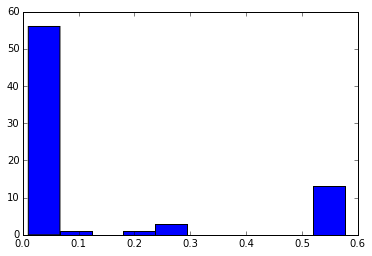

In [64]:
plt.hist(pep_demo.prob_post_bind_list)

In [65]:
## We now strive to figure out which are the error-prone domains

for peptide in PDZ_Data.peptides:
    calc_posterior(peptide,0)

for peptide in PDZ_Data.peptides:
    peptide.out_domains = []
    peptide.false_count = 0
    for i in range(len(peptide.prob_post_bind_list)):
        if (peptide.prob_post_bind_list[i] > peptide.lower_prob) & (fp_interaction_matrix[peptide.name][i] < 0):
            peptide.out_domains.append(PDZ_Data.domain_names[i])
            peptide.false_count +=1

(array([ 23.,  13.,   5.,   4.,   0.,   2.,   4.,   3.,   5.,   0.,   2.,
          2.,   1.,   0.,   0.,   0.,   3.,   1.,   3.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,   1.8,   2.6,   3.4,   4.2,   5. ,   5.8,   6.6,   7.4,
          8.2,   9. ,   9.8,  10.6,  11.4,  12.2,  13. ,  13.8,  14.6,
         15.4,  16.2,  17. ,  17.8,  18.6,  19.4,  20.2,  21. ,  21.8,
         22.6,  23.4,  24.2,  25. ,  25.8,  26.6,  27.4,  28.2,  29. ,
         29.8,  30.6,  31.4,  32.2,  33. ]),
 <a list of 1 Patch objects>)

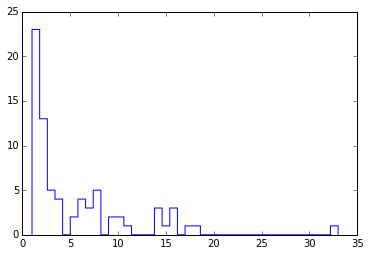

In [66]:
from collections import OrderedDict
freq_count = {domain:0 for domain in PDZ_Data.domain_names}
for peptide in PDZ_Data.peptides:
    for domain in PDZ_Data.domain_names:
        if domain in peptide.out_domains:
            freq_count[domain] +=1
count = list(freq_count.viewvalues())
plt.hist(count, bins = 40, histtype='step')

In [67]:
for peptide in PDZ_Data.peptides:
    print "{}\t {}\t {}".format(peptide.name, peptide.y_manip_bind*74, peptide.false_count)
    

AN2	 1.0	 1
APC	 0.0	 0
Aquaporin4	 2.0	 1
ASIC2	 0.0	 0
Caspr2	 5.0	 4
Cav2.2	 0.0	 0
Cftr	 17.0	 5
c-KIT	 0.0	 0
Claudin1	 3.0	 0
Cnksr2	 25.0	 2
Connexin43	 1.0	 2
CRIPT	 12.0	 3
CtBP1	 0.0	 0
Dlgap123	 6.0	 2
EphA71	 8.0	 0
EphB2	 1.0	 0
EphrinB12	 1.0	 0
ErbB4	 1.0	 0
Frizzled	 11.0	 5
GluR1	 2.0	 0
GluR2_1	 1.0	 0
GluR5_1	 1.0	 0
GlycphrinC	 1.0	 1
GRK6	 5.0	 3
Htr2c	 7.0	 2
JAM-1	 2.0	 0
KIF17	 2.0	 2
KIF1B	 11.0	 2
Kir2.1	 2.0	 7
Kv1.4	 9.0	 9
Lgltminase	 5.0	 0
Liprin2	 0.0	 0
Megalin	 4.0	 7
Mel1a/b	 4.0	 1
mGluR3	 1.0	 1
ctransprtr	 8.0	 1
Nav1.4	 14.0	 5
Nav1.5	 9.0	 8
Neurxin1/2	 5.0	 5
NMDAR2A	 7.0	 5
NMDAR2B	 8.0	 5
P2Y1	 4.0	 7
Parkin	 3.0	 0
PDGFR	 1.0	 1
PFK-M	 0.0	 0
PIX	 7.0	 8
PKC	 8.0	 3
PMCA1	 19.0	 5
Ril	 4.0	 6
Sapk3	 20.0	 4
SSTR2	 22.0	 2
Stargazin	 1.0	 2
Syndecan1	 1.0	 0
Syndecan2	 1.0	 0
TAZ	 18.0	 4
Trip6	 0.0	 0
TRPC4	 6.0	 2
AcvR1	 0.0	 0
AcvR2	 5.0	 3
AcvR2b	 3.0	 2
Cacna1a	 1.0	 0
Cav1.2	 3.0	 2
Cav2.3	 0.0	 0
Cav3.2	 0.0	 0
ITPR3	 0.0	 0
RYR2	 0.0	 

In [68]:
freq_count

{'Cipp (03/10)': 1,
 'Cipp (05/10)': 2,
 'Cipp (08/10)': 16,
 'Cipp (09/10)': 1,
 'Cipp (10/10)': 1,
 'D930005D10Rik (1/1)': 2,
 'Dlgh3 (1/1)': 1,
 'Dvl1 (1/1)': 1,
 'Dvl2 (1/1)': 1,
 'Dvl3 (1/1)': 2,
 'Erbin (1/1)': 5,
 'GRASP55 (1/1)': 2,
 'Gm1582 (2/3)': 14,
 'Grip1 (6/7)': 1,
 'Grip2 (5/7)': 10,
 'Harmonin (2/3)': 1,
 'HtrA1 (1/1)': 33,
 'HtrA3 (1/1)': 11,
 'Interleukin 16 (1/4)': 6,
 'LARG (1/1)': 4,
 'LIN-7A (1/1)': 4,
 'Lin7c (1/1)': 2,
 'Lnx1 (2/4)': 5,
 'Lrrc7 (1/1)': 2,
 'MUPP1 (01/13)': 1,
 'MUPP1 (05/13)': 1,
 'MUPP1 (10/13)': 6,
 'MUPP1 (11/13)': 1,
 'MUPP1 (12/13)': 1,
 'MUPP1 (13/13)': 2,
 'Magi-1 (2/6)': 3,
 'Magi-1 (4/6)': 2,
 'Magi-1 (6/6)': 2,
 'Magi-2 (5/6)': 6,
 'Magi-2 (6/6)': 9,
 'Magi-3 (2/5)': 2,
 'Magi-3 (5/5)': 8,
 'Mpp7 (1/1)': 1,
 'NHERF-1 (1/2)': 2,
 'NHERF-2 (2/2)': 15,
 'PAR-3 (3/3)': 1,
 'PAR3B (1/3)': 2,
 'PAR6B (1/1)': 1,
 'PDZ-RGS3 (1/1)': 16,
 'PSD95 (1/3)': 14,
 'PTP-BL (2/5)': 8,
 'Pdlim5 (1/1)': 1,
 'Pdzk1 (1/4)': 8,
 'Pdzk1 (3/4)': 1,
 'Pdzk11 (

Couple of interesting things found:

1. We have effectively reduced the binding probability to zero for those peptides which dont bind to any of the peptides. It will be interesting to see how these peptides behave when we perform mutations. 

2. The dependence on the threshold selected might play an important role for some peptide-protien pairs since the change of the threshold can affectively determine the binding probability of the peptide. 

3. We also note that there is a direct relation between the number of domains that a peptide binds to and the predicted probabtility of liaison. What is important to note is that if there is only one domain that a peptide binds to, the predicted probability of liaison is very low. Because for the extremely low value of $P(y_{manip})$ taken for such peptides. Maybe we can update this prior probability? 

Let us look at the relation between the number of domains that the peptide binds to and the max probability of the binding. 

In [175]:
np.max(PDZ_Data.peptides[PDZ_Data.pep_names.index('Cftr')].prob_post_bind_list)

0.65621229394350855

In [149]:
bind_probs = []
nb_bind = []
lwr_bounds = []
for peptide in PDZ_Data.peptides:
    calc_posterior(peptide,0)
for peptide in PDZ_Data.peptides:
    bind_probs.append(np.max(peptide.prob_post_bind_list))
    nb_bind.append(peptide.y_manip_bind*74)
    lwr_bounds.append(peptide.lower_prob)
    print "{}\t {}\t".format(peptide.y_manip_bind*74, np.max(peptide.prob_post_bind_list))

1.0	 0.0806045327556	
0.0	 0.0	
2.0	 0.150943393888	
0.0	 0.0	
5.0	 0.316831678271	
0.0	 0.0	
17.0	 0.656212293944	
0.0	 0.0	
3.0	 0.212860307126	
25.0	 0.765550227639	
1.0	 0.0806045327556	
12.0	 0.553314112533	
0.0	 0.0	
6.0	 0.360902250065	
8.0	 0.436860061522	
1.0	 0.0806045327556	
1.0	 0.0806045327556	
1.0	 0.0806045327556	
11.0	 0.527736123815	
2.0	 0.150943393888	
1.0	 0.0806045327556	
1.0	 0.0806045327556	
1.0	 0.0806045327556	
5.0	 0.316831678271	
7.0	 0.400715557321	
2.0	 0.150943393888	
2.0	 0.150943393888	
11.0	 0.527736123815	
2.0	 0.150943393888	
9.0	 0.469820547409	
5.0	 0.316831678271	
0.0	 0.0	
4.0	 0.267782422636	
4.0	 0.267782422636	
1.0	 0.0806045327556	
8.0	 0.436860061522	
14.0	 0.598930472095	
9.0	 0.469820547409	
5.0	 0.316831678271	
7.0	 0.400715557321	
8.0	 0.436860061522	
4.0	 0.267782422636	
3.0	 0.212860307126	
1.0	 0.0806045327556	
0.0	 0.0	
7.0	 0.400715557321	
8.0	 0.436860061522	
19.0	 0.688561710895	
4.0	 0.267782422636	
20.0	 0.703296692575	
22.0	 0.7

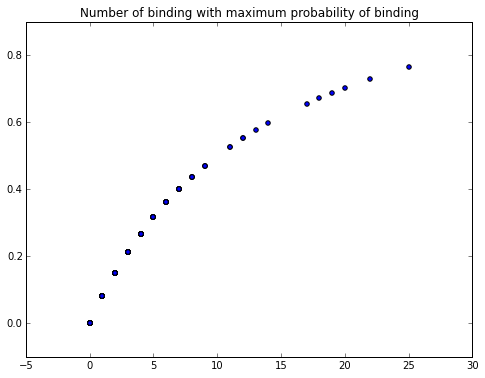

In [151]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Number of binding with maximum probability of binding" )
plt.scatter(np.asarray(nb_bind), np.asarray(bind_probs))

For the simulation with mutations, we shall be taking the newer probability which uses the updated probability. Thus the steps to take before I start the simulation, :

1. Calculate the probability of binding for each of the peptides using the posterior probability matrix for each of the peptides. This should ideally be a function which takes in a peptide sequence and spits out the posterior probability. 

2. Then I will have to calculate the log-likelihood which is the sum over all peptides of the log of the posterior probability. 

In [149]:
def calc_log_likeli(peptide):
    log_proba = [np.log(proba) for proba in peptide.prob_post_bind_list]
    peptide.log_lik = sum(log_proba)

In [151]:
calc_log_likeli(pep_demo)
print pep_demo.log_lik

-247.575351064


In [155]:
def log_likelihood(peptide, sequence):
    log_lik = 0.0
    for domain in PDZ_Data.domains:
        energy = eval_score(domain, sequence,2)
        if fp_interaction_matrix[peptide.name][i] > 0:
            proba = peptide.posterior_matrix[1,0]*sigmoid(energy,-1) + peptide.posterior_matrix[1,1]*sigmoid(energy)
        else:
            proba = peptide.posterior_matrix[0,0]*sigmoid(energy,-1) + peptide.posterior_matrix[0,1]*sigmoid(energy)
        log_lik += np.log(proba)   
    peptide.log_lik = log_lik
    return log_lik

In [156]:
log_likelihood(pep_demo, convert2int(pep_demo.sequence_bis))
#log_likelihood(PDZ_Data.peptides[34], convert2int(PDZ_Data.peptides[34].sequence_bis))

-14.05778943386005

In [175]:
log_dist = [log_likelihood(peptide,convert2int(peptide.sequence_bis)) for peptide in PDZ_Data.peptides]

(array([   0.,    2.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,
           2.,    2.,    1.,    1.,    1.,    3.,    3.,   11.,   12.,
          24.,  146.,    4.]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1]),
 <a list of 21 Patch objects>)

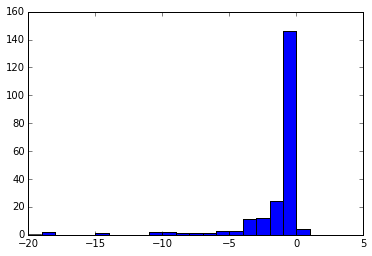

In [263]:
plt.hist(log_dist, bins=range(-20,2))

In [262]:
start = -3
end = -2
for i in range(len(log_dist)):
    if (log_dist[i] < end) & (log_dist[i] > start):
        
        print "{}\t {} ".format(PDZ_Data.pep_names[i], PDZ_Data.peptides[i].y_manip_bind*74)

Dlgap123	 6.0 
GRK6	 5.0 
Lgltminase	 5.0 
Neurxin1/2	 5.0 
Ril	 4.0 
TRPC4	 6.0 
AcvR2	 5.0 
Claudin9	 5.0 
Claudin10	 4.0 
Claudin15	 4.0 
NMDAR2D	 6.0 
TRPM6	 5.0 


In [219]:
ix = PDZ_Data.pep_names.index('Cftr')
pep_demo_2 = PDZ_Data.peptides[ix]

In [228]:
mut_seq = convert2int(pep_demo_2.sequence_bis)
y = np.random.randint(5)
z = np.random.randint(19)
mut_seq[y] = z
print pep_demo_2.sequence_bis
print convert2seq(mut_seq)
print log_likelihood(pep_demo_2,mut_seq)

['Q', 'E', 'T', 'R', 'L']
['Q', 'I', 'T', 'R', 'L']
-11.5052956218


In [223]:
print log_likelihood(pep_demo_2, convert2int(pep_demo_2.sequence_bis))

-14.0577894339


Things to do:

1. Calculate the cases where the updated model predicts a binding probability when its not supposed to, for each peptide. 
2. Calculate the frequency of occurrence for each of the domains in our data set. 
3. Compare ground state energy vs number of peptides bound to. 
4. Perform point wise mutations with a non-zero temperature 
5. Write up the results and the discussions with Simona 
6. Float the idea that perhaps a more pertinent thing to look at is the Free Energy and not just the energy. 